In [63]:
import os,re
import requests as rq
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy

In [64]:
data = rq.get("https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=List_of_hip_hop_musicians").json()
list_markup = data["query"]["pages"]["140853"]["revisions"][0]["*"]
link_regex = r"\* \[\[(.+?)[\(\]]"

rappers = re.findall(link_regex, list_markup)

In [65]:
with open("rappers.txt", 'w') as f:
    for r in rappers:
        f.write(r.encode('utf-8') + "\n")

In [157]:
import spotipy.oauth2 as oauth2

# When an error occurs saying the token expired, re-run this cell.
# Tokens are 1 hour I think.
client_id = 'e3344de9f0454df280cc34cdba040bf7'
client_secret = 'da09e980b2fb4f11a68a3c00a2669a7d'

credentials = oauth2.SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

In [67]:
def get_albums(rapper):
    results = spotify.search(q='artist:%s' % rapper,type='artist')
    
    artist_id = results['artists']['items'][0]['uri']
    
    albums = spotify.artist_albums(artist_id)
    
    # For some reason duplicates some albums. Wrap as a set
    return set([album['name'] for album in albums['items']])

In [68]:
def get_album_artists(album_name):
    results = spotify.search(q='album:%s' % album_name,type='album')
    
    album_id = results['albums']['items'][0]['uri']
    
    tracks = spotify.album_tracks(album_id)
    return set([artist['name']  
            for track in tracks['items']
            for artist in track['artists']])

In [69]:
def get_collaborators(rapper):
    """Returns a dictionary of album:artists entry"""
    
    albums = get_albums(rapper)
    
    return {album:list(get_album_artists(album)) for album in albums}

In [40]:
try:
    a = get_collaborators("2 Chainz")
except IndexError:
    print "FAILED"

FAILED


Do rappers that fail just not have any collaborators?

In [31]:
q = list([item for sublist in a.values() for item in sublist])

In [32]:
col_dict = {}
for i in q: 
    if i not in col_dict: 
        col_dict[i] =  1
    else: 
        col_dict[i] += 1

In [102]:
def get_rappers():
    
    def validate(name):
        # checks if the name has a
        illegal_chars = "|?:^*\""

        for c in illegal_chars:
            if c == '|':
                if name.find(c) > 0:
                    name = name.split("|")[1]
            if c == "\"":
                if name.find(c) > 0:
                    name = name.replace(r'"','',2)
            else: 
                name = name.replace(c,'')
        return name
    
    with open("data/rappers.txt".decode('utf-8'), "r") as f:
        rappers = f.read()
        
    return [validate(rapper).strip() for rapper in rappers.split("\n")]
rappers = get_rappers()

In [165]:
def find_collaborators(r):
    with open("data/albums/%s.txt" % r.decode('utf-8')) as fp:
        albums = eval(fp.read())
        
    artists = []
    for album in albums: 
        for artist in album['tracks']:
            for a in artist['collaborators']:
                artists.append(a)
    return artists

In [166]:
find_collaborators("6lack")

['6LACK',
 '6LACK',
 '6LACK',
 'Future',
 '6LACK',
 '6LACK',
 '6LACK',
 'J. Cole',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 'Offset',
 '6LACK',
 '6LACK',
 '6LACK',
 'Khalid',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 '6LACK',
 'Banks',
 '6LACK',
 'T-Pain']

In [167]:
def get_collaborator_count(collaborators):
    #creating a dictionary from the collaborators to count the number of collaborations for weighted edges
    col_dict = {}
    for c in collaborators:
        #don't include self as a rapper
        if c == r: 
            continue
        #add new collaborators to the dict with a count of 1
        if c not in col_dict: 
            col_dict[c] =  1
        #add one to the count of previous collaborators
        else: 
            col_dict[c] += 1
    return col_dict  

In [182]:
def create_network(rappers, network): 
    
    errors = []
    for r in list(rappers):
        try: 
            #get the collaborators from the data file in a list 
            collaborators = find_collaborators(r)
            
        except IndexError: 
            errors.append(r)
            continue
        except SyntaxError:
            errors.append(r)
            continue
        
        col_dict = get_collaborator_count(collaborators)
        
        for c in set(collaborators):
            #don't include self as a collaborator
            if c == r: 
                continue
            if c not in list(rappers):
                continue
            else:
                #get the weight for the edge as number of collaborations from dict
                w = col_dict[c]
                #add the weighted edges
                network.add_edge(r,c,weight=w)

                if network.degree(c) == 1 and w == 1:
                    network.remove_node(c)
                
        

In [ ]:
collaboration_network = nx.Graph()

In [183]:
collaboration_network_short = nx.Graph()
create_network(rappers, collaboration_network_short)

In [177]:
import json

In [178]:
with open('rappers_network.json', 'w') as fp:
    json.dump(nx.node_link_data(collaboration_network), fp)

In [184]:
with open('rappers_network_short.json', 'w') as fp:
    json.dump(nx.node_link_data(collaboration_network_short), fp)

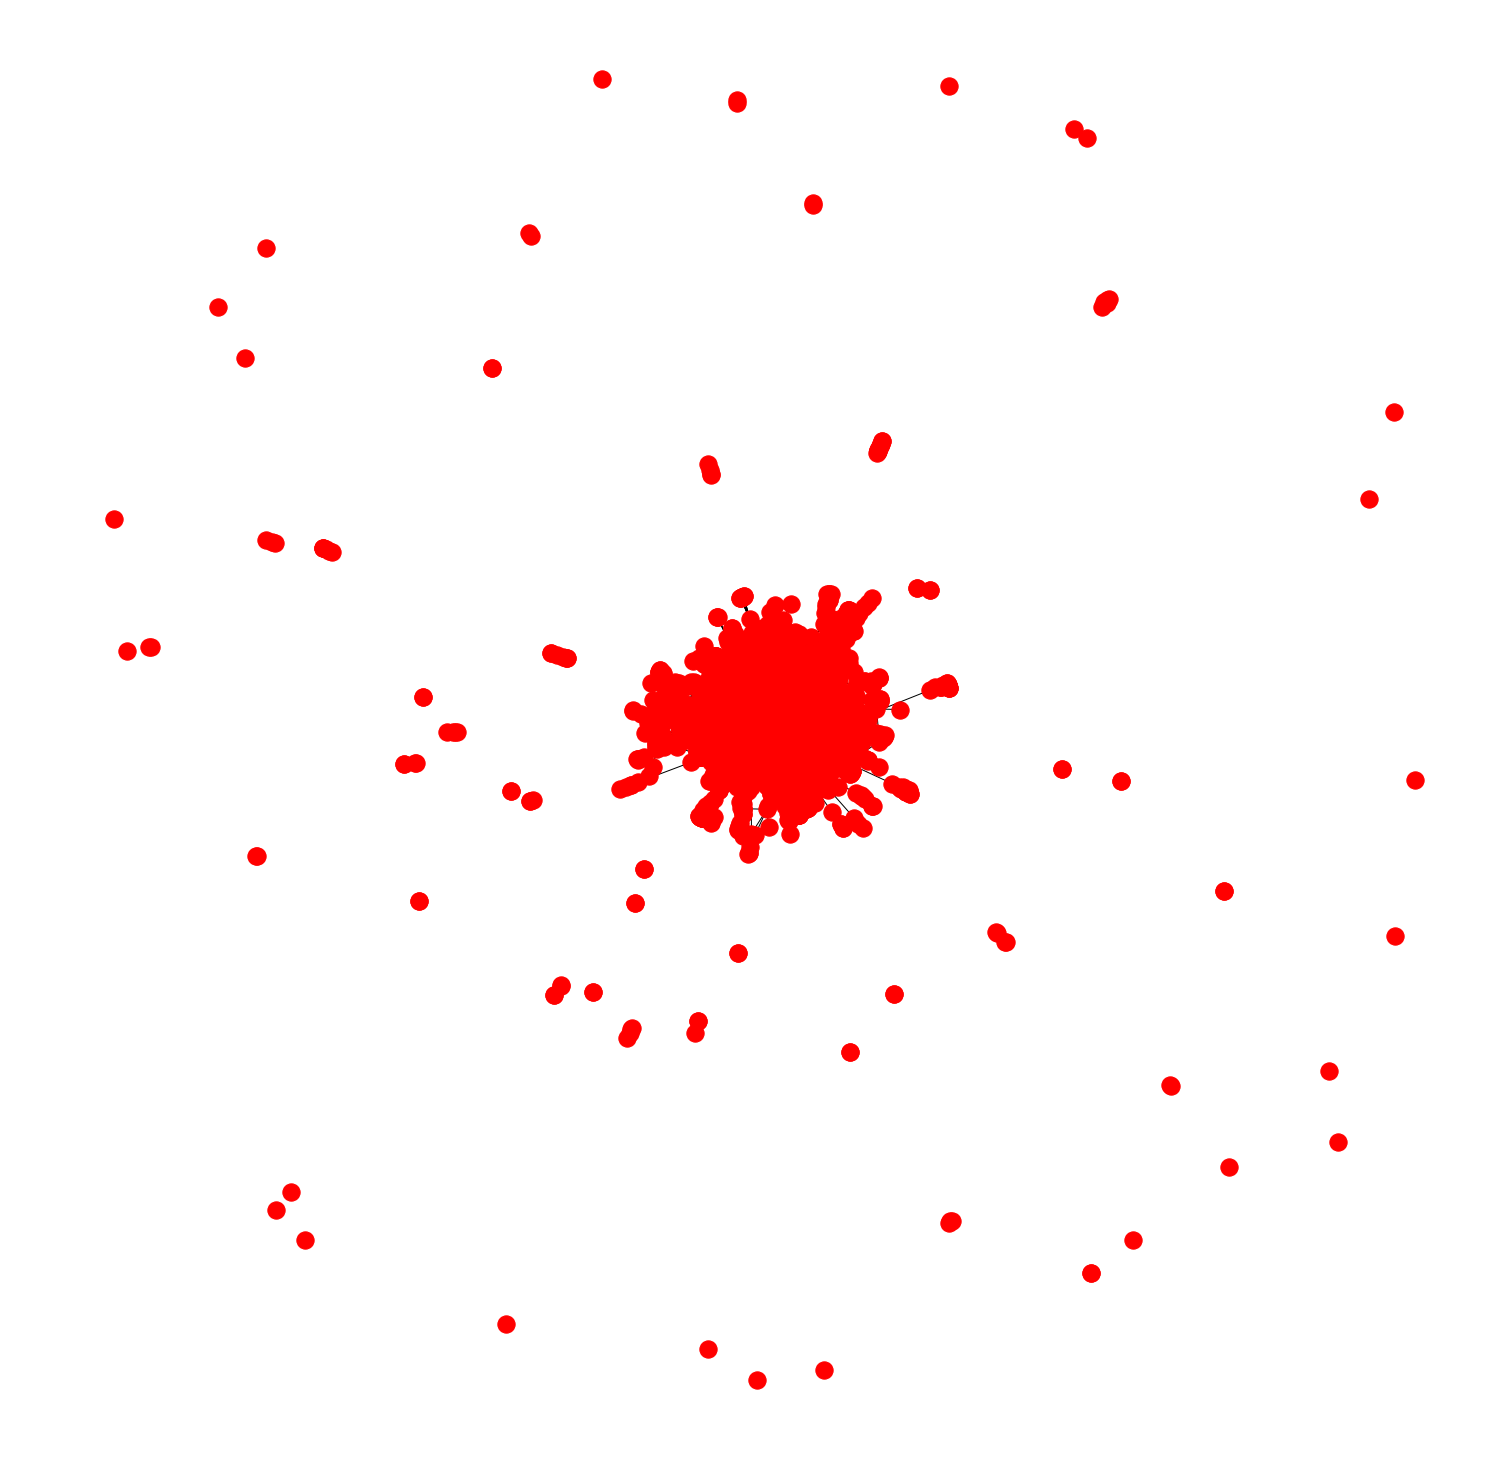

In [176]:
plt.figure(figsize=[20,20])
nx.draw(collaboration_network)
plt.show()